From: https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

In [50]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
import nltk

import warnings
warnings.filterwarnings('ignore')

In [2]:
len(twenty_train.target)

11314

In [3]:
len(twenty_test.target)

7532

In [4]:
twenty_train.target_names #prints all the categories
print("\n".join(twenty_train.data[0].split("\n")[:3])) #prints first line of the first data file

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(11314, 130107)

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 130107)

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [8]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

In [9]:
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

In [10]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.7738980350504514

In [11]:
probas = text_clf.predict_proba(twenty_test.data)

In [12]:
len(probas)

7532

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

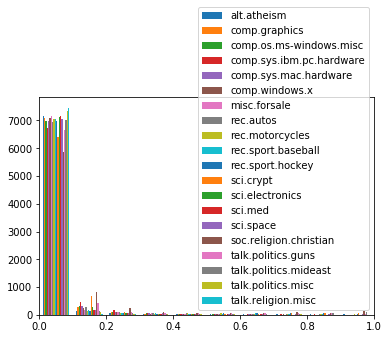

In [14]:
plt.hist(probas)
plt.xlim(0.0,1)
#plt.ylim(0,7500)
plt.legend(twenty_test.target_names);

In [15]:
from sklearn.metrics import roc_curve, auc

In [16]:
fpr, tpr, thresholds = roc_curve(twenty_test.target
                                , probas[:,0]
                                , pos_label=0)

In [17]:
roc_auc = auc(fpr, tpr)

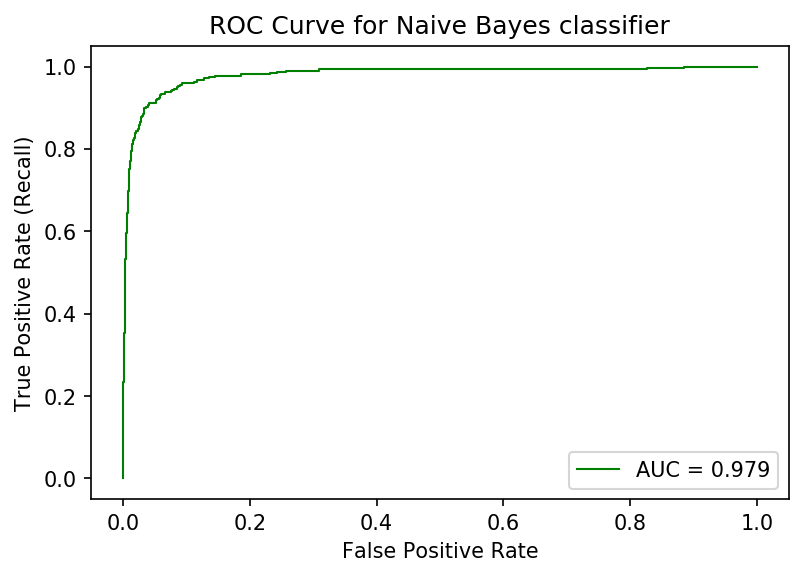

In [18]:
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for Naive Bayes classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import (precision_recall_curve
                             , average_precision_score
                             , auc)

In [30]:
# our target labels are not binary so we have to binarize it
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
Y = label_binarize(twenty_train.target, classes = [_ for _ in range(1,21)])
n_classes = Y.shape[1]
n_classes

20

In [46]:
X_train, X_test, y_train, y_test = train_test_split(twenty_train.data
                                                    , Y
                                                    , random_state = 42)

#X_train = twenty_train.data
#X_test = twenty_test.data
#y_train = twenty_train.target
#y_test = twenty_test.target

from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

In [47]:
model = OneVsRestClassifier(svm.LinearSVC(random_state=42))

In [48]:
text_OVRC = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('OVRC', OneVsRestClassifier(svm.LinearSVC(random_state=42))),
                    ])

In [51]:
text_OVRC.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('OVRC',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight=None,
            

In [52]:
y_pred = text_OVRC.decision_function(X_test)

In [53]:
y_test.reshape(-1,1)[:, 0]

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
y_pred[:, 0]

array([-1.21375574, -0.8628448 , -0.87939585, ...,  0.00628931,
       -1.28506339, -1.01479026])

In [55]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, 0]
                                                       , y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i]
                                                  , y_pred[:, i])

# a micro-avg: quanitfiying score on all classes jointly
precision['micro'], recall['micro'], _ = precision_recall_curve(y_test.ravel()
                                                                  , y_pred.ravel())

average_precision['micro'] = average_precision_score(y_test
                                                    , y_pred
                                                    , average='micro')

print("Avg precision score, micro avg over all classes: {0:0.2f}".format(average_precision['micro']))

Avg precision score, micro avg over all classes: 0.85


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.85')

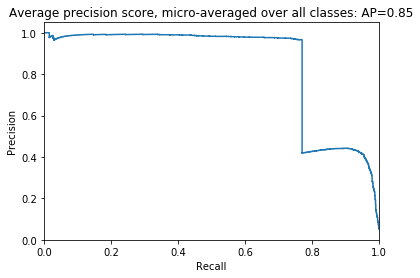

In [56]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [44]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
             }

In [45]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

/home/david/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [47]:
gs_clf.best_score_

0.9067526957751458

In [48]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [49]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
                    ])

In [50]:
import nltk
nltk.download()
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                             ('tfidf', TfidfTransformer()),
                             ('mnb', MultinomialNB(fit_prior=False)),
                            ])
text_mnb_stemmed = text_mnb_stemmed.fit(twenty_train.data, twenty_train.target)
predicted_mnb_stemmed = text_mnb_stemmed.predict(twenty_test.data)
np.mean(predicted_mnb_stemmed == twenty_test.target)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


0.8167817312798725